In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
import xgboost as xgb
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import datetime
# from pmdarima import auto_arima
import warnings

try:
    from prophet import Prophet
    PROPHET_AVAILABLE = True
except ImportError:
    PROPHET_AVAILABLE = False
    print("WARNING: 'prophet' library not found. The Prophet section will be skipped.")
    print("Install it via: pip install prophet")

# Suppress warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

Install it via: pip install prophet


## Helper functions

In [2]:
dow_map = [datetime.strftime(datetime(1,1,i+1), "%A") for i in range(7)]
month_map = [datetime.strftime(datetime(1,i+1,1), "%B") for i in range(12)]

In [3]:
aqi_map = [
    "Good", 
    "Moderate", 
    "Unhealthy for Sensitive Groups",
    "Unhealthy",
    "Very Unhealthy",
    "Hazardous"
]
def get_aqi_category(aqi, as_strings=False):
    """Returns the textual category for a given AQI value (US Standard)."""
    if aqi is None or np.isnan(aqi): return None
    val = int(aqi); aqi_idx = 5
    if val <= 50: aqi_idx = 0
    elif val <= 100: aqi_idx = 1
    elif val <= 150: aqi_idx = 2
    elif val <= 200: aqi_idx = 3
    elif val <= 300: aqi_idx = 4
    if as_strings: return aqi_map[aqi_idx]
    return aqi_idx

In [4]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

def check_stationarity(series):
    # From https://machinelearningmastery.com/time-series-data-stationary-python/
    result = adfuller(series.values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

## 1. Setup Data

In [5]:
df = pd.read_csv("./data/clean_data.csv")
# Time to datetime index
df["time"] = pd.to_datetime(df["time"], format="%Y-%m-%d %H:%M:%S")
df.set_index("time", inplace=True)
# Set freq
df.index.freq="1H"
# Convert month and day-of-week to numbers
df["month"] = df.index.month - 1
df["day_of_week"] = df.index.weekday
# Sort to make sure
df.sort_index(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28865 entries, 2022-08-05 07:00:00 to 2025-11-19 23:00:00
Freq: H
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   temperature_2m        28865 non-null  float64
 1   relative_humidity_2m  28865 non-null  int64  
 2   rain                  28865 non-null  float64
 3   wind_direction_10m    28865 non-null  int64  
 4   wind_speed_10m        28865 non-null  float64
 5   aqi_pm25              28865 non-null  float64
 6   hour                  28865 non-null  int64  
 7   month                 28865 non-null  int32  
 8   day_of_week           28865 non-null  int32  
 9   is_weekend            28865 non-null  bool   
 10  is_raining            28865 non-null  bool   
dtypes: bool(2), float64(4), int32(2), int64(3)
memory usage: 2.0 MB


## 2. EDA

### 2.1. PM2.5 vs Time

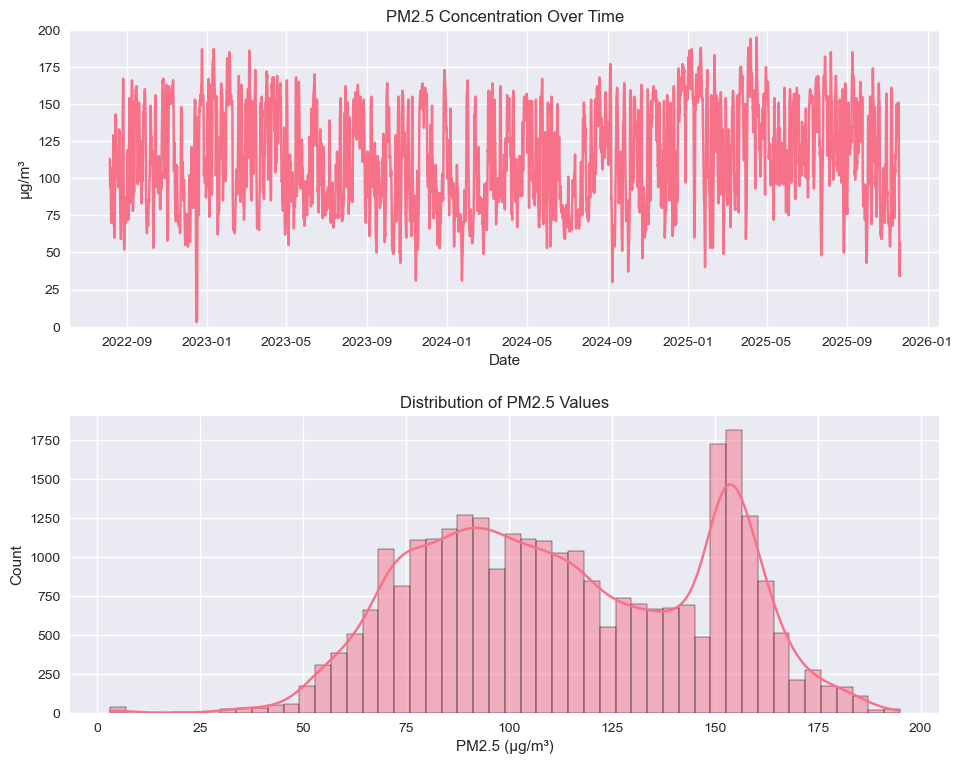

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
# Values over time
ax[0].plot(df.index, df["aqi_pm25"], label="PM2.5 Concentration")
ax[0].set(
    title="PM2.5 Concentration Over Time",
    xlabel="Date",
    ylabel="µg/m³", ylim=[0,200]
)
# Distribution over time
sns.histplot(df["aqi_pm25"], kde=True, bins=50, ax=ax[1])
ax[1].set(
    title="Distribution of PM2.5 Values",
    xlabel="PM2.5 (µg/m³)",
)
fig.tight_layout(pad=2.0)
fig.show()

In [7]:
# Check stationary
check_stationarity(df["aqi_pm25"])

ADF Statistic: -13.536176
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


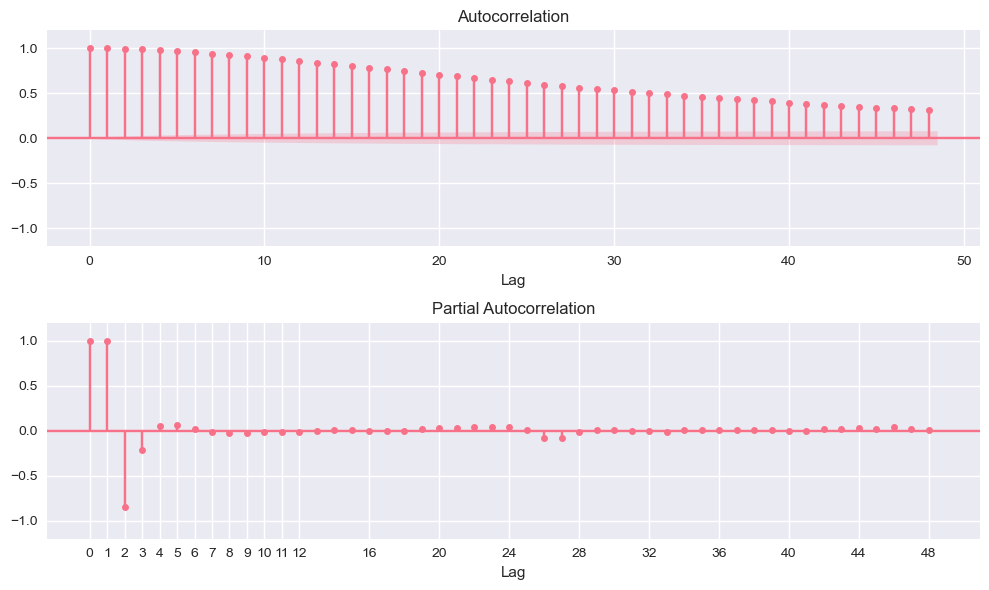

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 2*3))
plot_acf(df["aqi_pm25"], lags=48, ax=axes[0])
plot_pacf(df["aqi_pm25"], lags=48, ax=axes[1])
for ax in axes: ax.set_ylim([-1.2, 1.2]); ax.set(xlabel="Lag")
axes[1].set_xticks([i for i in range(12)] + [i for i in range(12, 49, 4)])
plt.tight_layout()
plt.show()

### 2.2. PM2.5 vs TimeCycle

#### 2.2.1. PM2.5 vs Hours

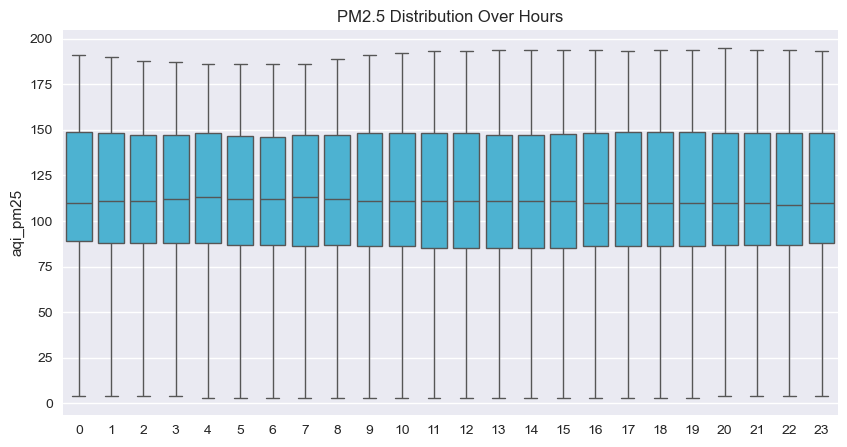

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(df, x="hour", y="aqi_pm25", ax=ax, color="#37BEE7")
ax.set(xlabel=None, title="PM2.5 Distribution Over Hours")
ax.set_xticks(range(24))
plt.show()

In [10]:
df_is_hour = df["hour"].apply(
    lambda x: pd.Series(
        {f"is_hour_{i}": x==i 
        for i in range(24)}
    ))

corr_by_hour = df_is_hour.corrwith(df["aqi_pm25"])
print(f"Max absolute correlation by Hours: {max(abs(corr_by_hour)):.5f}")

Max absolute correlation by Hours: 0.00282


#### 2.2.2. PM2.5 vs DOW

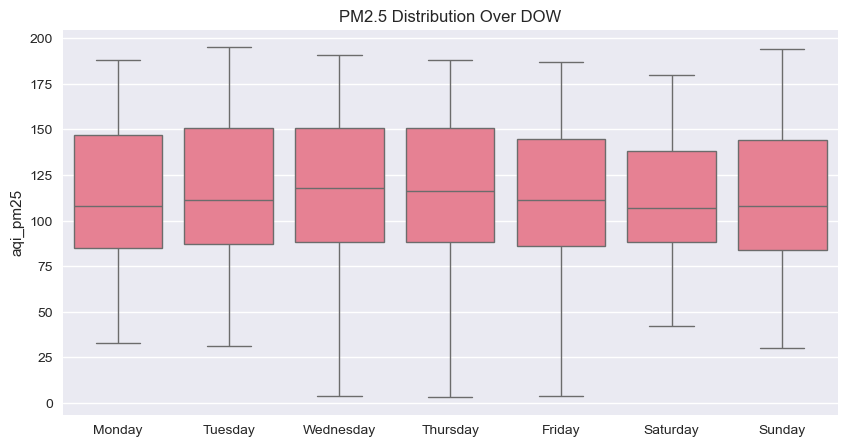

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(df, x="day_of_week", y="aqi_pm25", ax=ax)
ax.set(xlabel=None, title="PM2.5 Distribution Over DOW")
ax.set_xticks(range(7), dow_map)
plt.show()

In [12]:
df_is_dow = df["day_of_week"].apply(
    lambda x: pd.Series(
        {f"is_{dow_map[i].lower()}": x==i 
        for i in range(7)}
    ))
corr_by_dow = df_is_dow.corrwith(df["aqi_pm25"])
print(f"Max absolute correlation by DOW: {max(abs(corr_by_dow)):.5f}")

Max absolute correlation by DOW: 0.03765


#### 2.2.3. PM2.5 vs Month

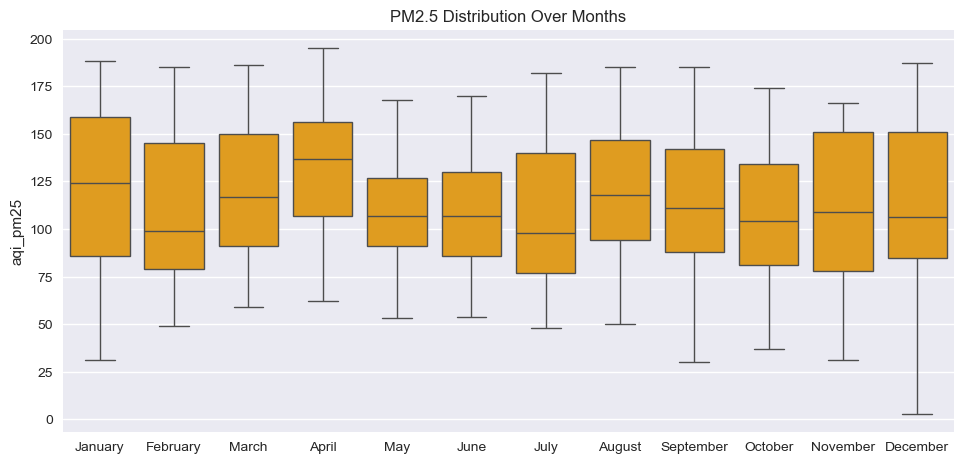

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(df, x="month", y="aqi_pm25", ax=ax, color="orange")
ax.set(xlabel=None, title="PM2.5 Distribution Over Months",)
ax.set_xticks(range(12), month_map)
fig.tight_layout(pad=2.0)
fig.show()

In [14]:
df_is_month = df["month"].apply(
    lambda x: pd.Series(
        {f"is_{month_map[i].lower()}": x==i 
        for i in range(12)}
    ))
corr_by_month = df_is_month.corrwith(df["aqi_pm25"])
print(f"Max absolute correlation by Months: {max(abs(corr_by_month)):.5f}")

Max absolute correlation by Months: 0.14851


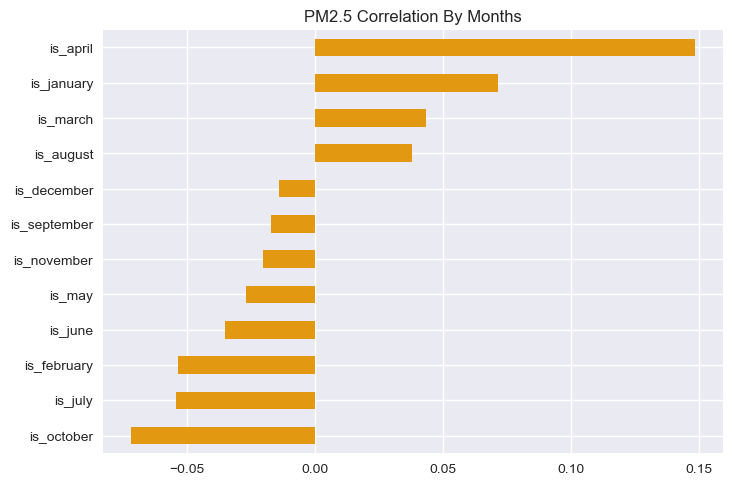

In [15]:
corr_by_month.sort_values().plot(
    kind="barh",
    color="#E29911",
    title="PM2.5 Correlation By Months")
plt.show()

### 2.3. PM2.5 vs Wind (Speed & Direction)

In [16]:
print("Wind direction range:\t[{}, {}]".format(
    df["wind_direction_10m"].min(), df["wind_direction_10m"].max()
))
print("Wind speed range:\t[{}, {}]".format(
    df["wind_speed_10m"].min(), df["wind_speed_10m"].max()
))

Wind direction range:	[1, 360]
Wind speed range:	[0.0, 60.7]


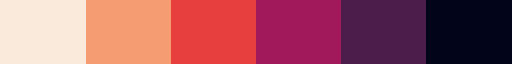

In [17]:
cmap = sns.color_palette("rocket_r", as_cmap=True).resampled(6)
cmap

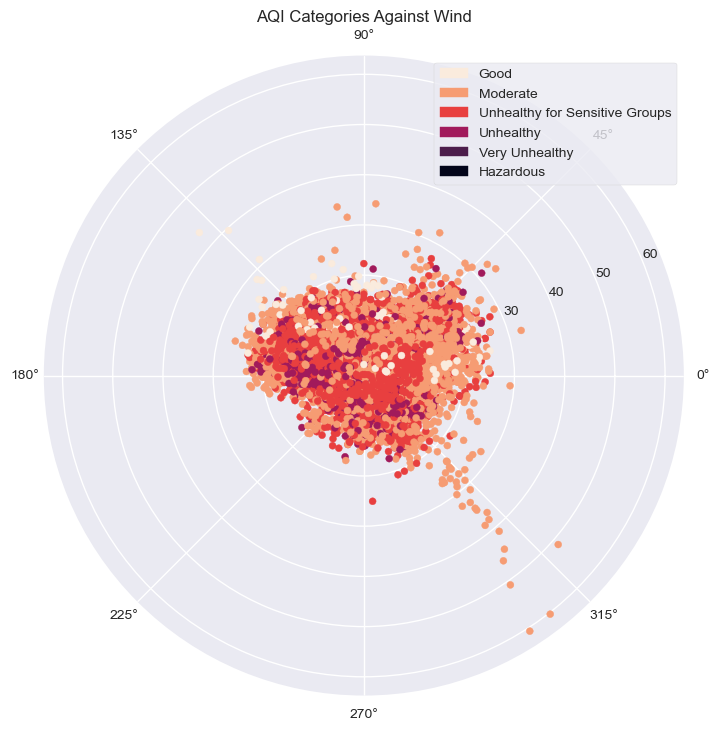

In [18]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)

theta = (df["wind_direction_10m"] % 360) * np.pi / 180
radii = df["wind_speed_10m"]
aqi_category = df["aqi_pm25"].apply(get_aqi_category)

scatter = ax.scatter(
    theta, radii,
    c=cmap(aqi_category), s=25.0,
)
ax.legend(handles=[
    mpatches.Patch(color=cmap(i),label=aqi_map[i])
    for i in range(len(aqi_map))
], loc="upper right", frameon=True)
ax.set(title="AQI Categories Against Wind")
plt.show()

In [19]:
def get_wind_components(x):
    theta = (x["wind_direction_10m"] % 360) / 180 * np.pi 
    return pd.Series({
        "wind_sin": np.sin(theta),
        "wind_cos": np.cos(theta),
        "wind_speed": x["wind_speed_10m"]
    })

df_wind_comps = df.apply(get_wind_components, axis=1) 
df_wind_comps.head()

,wind_sin,wind_cos,wind_speed
time,,,
2022-08-05 07:00:00,0.358368,0.933580,6.2
2022-08-05 08:00:00,0.156434,0.987688,6.6
2022-08-05 09:00:00,0.139173,0.990268,5.1
2022-08-05 10:00:00,0.469472,0.882948,5.3
2022-08-05 11:00:00,0.224951,0.974370,4.8


In [20]:
df_wind_comps.corrwith(df["aqi_pm25"])

wind_sin      0.000420
wind_cos     -0.111836
wind_speed   -0.303790
dtype: float64

### 2.4. PM2.5 vs Temperature+Humidity

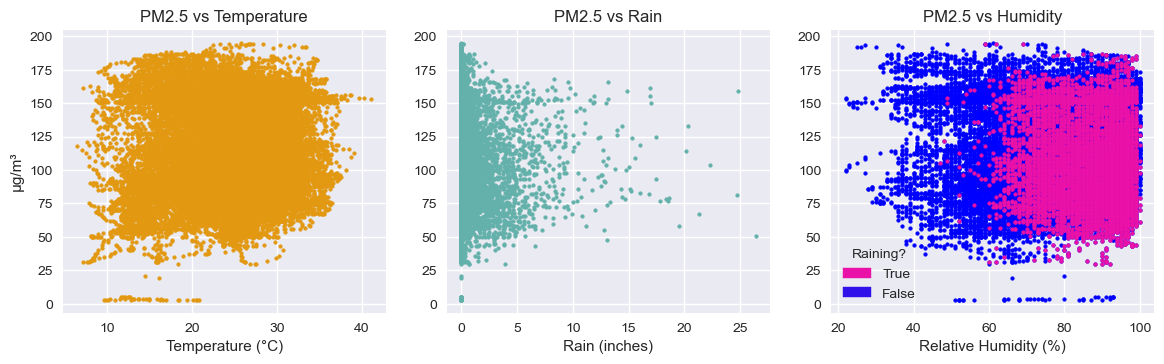

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(12,4))
axes[0].scatter(
    df["temperature_2m"], 
    df["aqi_pm25"], 
    c="#E29911", s=7.0)
axes[0].set(
    title="PM2.5 vs Temperature", 
    xlabel="Temperature (°C)", ylabel="µg/m³"
)
axes[1].scatter(
    df["rain"], 
    df["aqi_pm25"], 
    c="#63B1AA", s=7.0)
axes[1].set(
    title="PM2.5 vs Rain",
    xlabel="Rain (inches)"
)
axes[2].scatter(
    df["relative_humidity_2m"], 
    df["aqi_pm25"], 
    c="blue", s=7.0)
axes[2].scatter(
    df["relative_humidity_2m"][df["is_raining"]], 
    df["aqi_pm25"][df["is_raining"]], 
    c="#E911A8", s=7.0)
axes[2].set(
    title="PM2.5 vs Humidity",
    xlabel="Relative Humidity (%)"
)
plt.legend(title="Raining?", handles=[
    mpatches.Patch(color="#E911A8",label="True"),
    mpatches.Patch(color="#3111E9",label="False"),
], loc="lower left")
plt.tight_layout(pad=2.0)
plt.show()

In [22]:
df[["temperature_2m", 
    "relative_humidity_2m", 
    "rain", 
    "is_raining"
]].corrwith(df["aqi_pm25"])

temperature_2m          0.038011
relative_humidity_2m   -0.003122
rain                   -0.078311
is_raining             -0.137225
dtype: float64

## 3. Feature Selection

In [23]:
FEATURES = [
    "aqi_pm25",     # Main feature
    "wind_speed",   # |corr| = 0.30379
    "wind_cos",     # |corr| = 0.11183
    "is_april",     # |corr| = 0.14851
    "is_raining",   # |corr| = 0.13722
]

In [24]:
data_final = pd.DataFrame(
    index=df.index,
    data={
        "aqi_pm25": df["aqi_pm25"],
        "wind_speed": df_wind_comps["wind_speed"],
        "wind_cos": df_wind_comps["wind_cos"],
        "is_april": df_is_month["is_april"],
        "is_raining": df["is_raining"],
    }
)

In [25]:
data_final.to_csv("../data/features.csv")

## 4. Modeling

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split 
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Torch:", torch.__version__)
print("Using", DEVICE:="cuda" if torch.cuda.is_available() else "cpu")

Torch: 2.9.1+cu130
Using cuda


In [126]:
aqi_scaler = MinMaxScaler((0, 1))
df = pd.read_csv("../data/features.csv")
df["time"] = pd.to_datetime(df["time"], format="%Y-%m-%d %H:%M:%S")
df.set_index("time", inplace=True)
df.index.freq="1H"
data = df[["aqi_pm25"]].values.astype("float32")
data = aqi_scaler.fit_transform(data)

In [127]:
def create_sequences(data, seq_length):  
    xs, ys = [], []  
    for i in range(len(data) - seq_length):  
        x = data[i:i+seq_length]
        y = data[i+1:i+seq_length+1]   # PM2.5
        xs.append(x)  
        ys.append(y)  
    return np.array(xs), np.array(ys)  
 
SEQ_LENGTH = 24 
X, y = create_sequences(data, SEQ_LENGTH)  
print(X.shape)
print(y.shape)


(28841, 24, 1)
(28841, 24, 1)


In [128]:
# Split data into train and test sets  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)  

# Convert arrays to PyTorch tensors
# Shape: (batch, seq, input_size)
X_train = torch.tensor(X_train, device=DEVICE)
y_train = torch.tensor(y_train, device=DEVICE)  
X_test = torch.tensor(X_test, device=DEVICE)
y_test = torch.tensor(y_test, device=DEVICE) 

In [129]:
class LSTMPredictor(nn.Module):

    def __init__(self, input_dim=1, hidden_dim=64):
        super(LSTMPredictor, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.lstm1 = nn.LSTMCell(input_dim, self.hidden_dim)
        self.lstm2 = nn.LSTMCell(self.hidden_dim, self.hidden_dim)
        self.linear = nn.Linear(self.hidden_dim, 1)
    

    def forward(self, x: torch.Tensor, future=0):

        batch, dtype, device = x.size(0), x.dtype, x.device
        outputs = []
        
        _h1 = torch.zeros(batch, self.hidden_dim, dtype=dtype, device=device)
        _c1 = torch.zeros(batch, self.hidden_dim, dtype=dtype, device=device)
        _h2 = torch.zeros(batch, self.hidden_dim, dtype=dtype, device=device)
        _c2 = torch.zeros(batch, self.hidden_dim, dtype=dtype, device=device)

        for input_t in x.split(1, dim=1):  
            _h1, _c1 = self.lstm1(input_t.squeeze(1), (_h1, _c1))
            _h2, _c2 = self.lstm2(_h1, (_h2, _c2))
            output = self.linear(_h2)
            outputs.append(output)

        for _ in range(future):
            _h1, _c1 = self.lstm1(output, (_h1, _c1))
            _h2, _c2 = self.lstm2(_h1, (_h2, _c2))
            output = self.linear(_h2)
            outputs.append(output)
        if future > 0: return outputs
    
        outputs = torch.stack(outputs, dim=1)
        return outputs

In [130]:
model = LSTMPredictor().to(DEVICE).eval()
train_loader = DataLoader(TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
X_sample, y_sample = next(iter(train_loader))
print(model(X_sample).shape)
print(y_sample.shape)

torch.Size([8, 24, 1])
torch.Size([8, 24, 1])


In [131]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

EPOCHS = 10

losses = [] 
  
for epoch in range(EPOCHS):
    print(f"- Epoch: {epoch+1}/{EPOCHS}") 
    model.train()
    ep_loss = 0
    for i, (X_batch, y_batch) in enumerate(train_loader):
        optimizer.zero_grad() 
        y_pred = model(X_batch) 
        loss = criterion(y_pred, y_batch)  # Compute loss 
        loss.backward() 
        optimizer.step()

        ep_loss += loss.item()
        print(f"> Batch: {i+1}/{len(train_loader)}", end="\r" if i + 1 < len(train_loader) else " - ")
    print(f"Loss: {ep_loss:.3f}")
    losses.append(loss)

- Epoch: 1/10
> Batch: 2884/2884 - Loss: 2.223
- Epoch: 2/10
> Batch: 2884/2884 - Loss: 0.254
- Epoch: 3/10
> Batch: 2884/2884 - Loss: 0.147
- Epoch: 4/10
> Batch: 2884/2884 - Loss: 0.163
- Epoch: 5/10
> Batch: 2884/2884 - Loss: 0.131
- Epoch: 6/10
> Batch: 2884/2884 - Loss: 0.119
- Epoch: 7/10
> Batch: 2884/2884 - Loss: 0.111
- Epoch: 8/10
> Batch: 2884/2884 - Loss: 0.099
- Epoch: 9/10
> Batch: 2884/2884 - Loss: 0.100
- Epoch: 10/10
> Batch: 2884/2884 - Loss: 0.101


In [ ]:
with torch.no_grad():
    model.eval()
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

2884

In [114]:
ep_loss

1.831681268941793

In [ ]:
for a, b in :
    print(a, b)
    break

tensor([[[ 9.2708e-01,  1.4662e-01,  8.9101e-01,  0.0000e+00,  0.0000e+00],
         [ 9.2188e-01,  1.5980e-01,  9.2718e-01,  0.0000e+00,  0.0000e+00],
         [ 9.2188e-01,  1.3180e-01,  8.2904e-01,  0.0000e+00,  0.0000e+00],
         [ 9.1667e-01,  1.0379e-01, -3.4899e-02,  0.0000e+00,  0.0000e+00],
         [ 9.1667e-01,  1.3344e-01, -7.3135e-01,  0.0000e+00,  0.0000e+00],
         [ 9.1667e-01,  1.4003e-01, -8.4805e-01,  0.0000e+00,  0.0000e+00],
         [ 9.1667e-01,  9.2257e-02, -7.6604e-01,  0.0000e+00,  0.0000e+00],
         [ 9.2188e-01,  1.7298e-01, -7.7715e-01,  0.0000e+00,  0.0000e+00],
         [ 9.2188e-01,  2.0099e-01, -7.9864e-01,  0.0000e+00,  0.0000e+00],
         [ 9.2188e-01,  1.9110e-01, -8.8295e-01,  0.0000e+00,  0.0000e+00],
         [ 9.2188e-01,  1.6969e-01, -9.4552e-01,  0.0000e+00,  0.0000e+00],
         [ 9.1146e-01,  1.5980e-01, -9.6593e-01,  0.0000e+00,  0.0000e+00],
         [ 9.0625e-01,  1.3180e-01, -9.9452e-01,  0.0000e+00,  0.0000e+00],
         [ 9

In [53]:
a.split(1, dim=1)[0].shape

torch.Size([8, 1, 5])

In [60]:
model(a).shape

torch.Size([8, 24, 5])

In [63]:
with torch.no_grad():
    model.eval()
    y_pred = model(X_test)

In [64]:
y_pred

tensor([[[ 8.1888e-01,  1.5941e-01, -6.2265e-01,  5.6478e-03,  6.4958e-02],
         [ 8.4164e-01,  1.6894e-01, -7.2900e-01,  8.2497e-03,  1.7446e-02],
         [ 8.4388e-01,  2.1079e-01, -6.4602e-01,  5.9768e-03,  3.7864e-02],
         ...,
         [ 8.3036e-01,  6.9151e-02, -7.6841e-01,  1.3686e-02,  4.9704e-03],
         [ 8.3832e-01,  5.6851e-02, -8.8743e-01,  1.6087e-02,  2.2347e-02],
         [ 8.3461e-01,  1.3916e-01, -9.3607e-01,  1.0328e-02, -4.4288e-02]],

        [[ 8.1021e-01,  1.6997e-01, -6.8101e-01,  5.7247e-03,  5.8548e-02],
         [ 8.3020e-01,  1.9443e-01, -6.9633e-01,  8.0126e-03,  2.3963e-02],
         [ 8.5754e-01,  1.7725e-01, -4.8828e-01,  2.9602e-03,  6.0850e-02],
         ...,
         [ 8.3804e-01,  5.6876e-02, -8.8723e-01,  1.6100e-02,  2.2456e-02],
         [ 8.3432e-01,  1.3904e-01, -9.3632e-01,  1.0319e-02, -4.3444e-02],
         [ 8.5074e-01,  1.4092e-01, -9.3791e-01,  8.5353e-03, -6.3688e-05]],

        [[ 7.8595e-01,  1.8559e-01, -6.5004e-01,  6.3336

In [10]:
a.shape

torch.Size([8, 24, 5])

In [125]:
y_train.shape

torch.Size([23072, 24, 1])

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

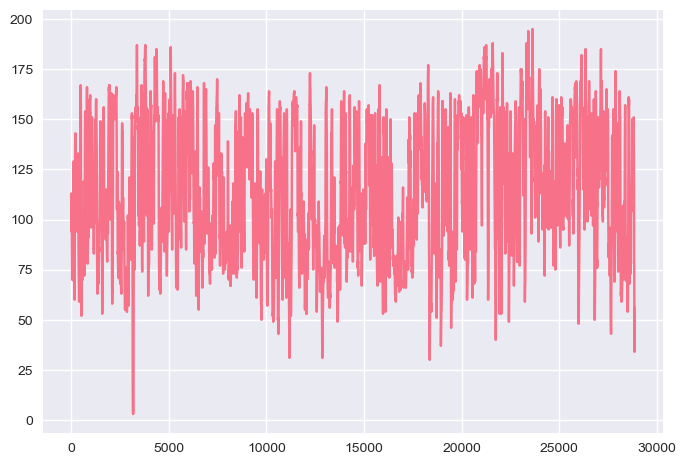

In [ ]:
df["aqi_pm25"].plot()
plt.plot(

### 4.1. LSTM

In [ ]:
#

In [28]:
def evaluate_multi_step(name, y_true, y_pred):
    """
    Evaluates multi-step forecasts and prints a formatted table.
    Dynamically handles inputs with fewer than 24 columns (e.g. only t+1).
    
    y_true: numpy array/DataFrame of shape (n_samples, n_horizons)
    y_pred: numpy array/DataFrame of shape (n_samples, n_horizons)
    """
    
    # 1. Convert to Numpy
    if hasattr(y_true, 'values'):
        y_true = y_true.values
    if hasattr(y_pred, 'values'):
        y_pred = y_pred.values
        
    # 2. Handle 1D inputs (Shape N,) -> Reshape to (N, 1)
    if y_true.ndim == 1:
        y_true = y_true.reshape(-1, 1)
    if y_pred.ndim == 1:
        y_pred = y_pred.reshape(-1, 1)

    # 3. Determine available columns based on Prediction input
    # We assume y_true corresponds to y_pred (or has at least as many cols)
    num_cols = y_pred.shape[1]
        
    # Define the horizons we want to report
    horizons = [1, 2, 3, 6, 12, 24]
    
    # Header Formatting
    header = f"{'Metric':<10} |"
    for h in horizons:
        header += f" {'t+'+str(h):<8} |"
    header += f" {'Overall':<8}"
    
    print(f"\n--- {name} Performance ---")
    print("-" * len(header))
    print(header)
    print("-" * len(header))
    
    # 4. Calculate Per-Step Metrics
    step_results = {}
    
    for h in horizons:
        col_idx = h - 1
        
        # Only calculate if we have data for this horizon
        if col_idx < num_cols:
            # Safely slice both arrays
            # (Assumes y_true has at least as many columns as y_pred)
            if col_idx < y_true.shape[1]:
                true_col = y_true[:, col_idx]
                pred_col = y_pred[:, col_idx]
                
                rmse = np.sqrt(mean_squared_error(true_col, pred_col))
                mae = mean_absolute_error(true_col, pred_col)
                r2 = r2_score(true_col, pred_col)
                
                step_results[h] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}
            else:
                 # y_pred has col but y_true doesn't (mismatch)
                 step_results[h] = None
        else:
            # Horizon beyond what was predicted
            step_results[h] = None

    # 5. Calculate Overall Metrics (Average across valid columns)
    # We limit y_true to the same number of columns as y_pred for fairness
    if num_cols > 0:
        y_true_sliced = y_true[:, :num_cols]
        y_pred_sliced = y_pred[:, :num_cols]
        
        overall_rmse = np.sqrt(mean_squared_error(y_true_sliced, y_pred_sliced))
        overall_mae = mean_absolute_error(y_true_sliced, y_pred_sliced)
        overall_r2 = r2_score(y_true_sliced, y_pred_sliced)
    else:
        overall_rmse = overall_mae = overall_r2 = None

    # 6. Print Rows
    for metric_name in ['RMSE', 'MAE', 'R2']:
        row_str = f"{metric_name:<10} |"
        
        for h in horizons:
            val = step_results.get(h)
            
            if val is not None:
                # Format actual numbers
                fmt = "<8.3f" if metric_name == 'R2' else "<8.2f"
                row_str += f" {val[metric_name]:{fmt}} |"
            else:
                # Format empty cell
                row_str += f" {'-':<8} |"
        
        # Add Overall column
        if overall_rmse is not None:
            val = overall_r2 if metric_name == 'R2' else (overall_rmse if metric_name == 'RMSE' else overall_mae)
            fmt = "<8.3f" if metric_name == 'R2' else "<8.2f"
            row_str += f" {val:{fmt}}"
        else:
            row_str += f" {'-':<8}"
            
        print(row_str)
    print("-" * len(header))

In [29]:
evaluate_multi_step('Persistence (Baseline)', y_test, y_pred_persist)

NameError: name 'y_test' is not defined